# SVD: Distance Matrix Job

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

import seaborn as sns

import numpy as np
import pandas as pd

import logging
import multiprocessing as mp

from surprise import SVD

import api
import model as ml
import util as ut
from logger import LoggerBuilder
from domain_context import DomainContext 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
LoggerBuilder.build()

In [5]:
TEMP_PATH                         = '../../temp'
INPUT_INTERACTIONS_PATH           = f'{TEMP_PATH}/input_interations.csv'
INTERACTIONS_PATH                 = f'{TEMP_PATH}/interations.csv'
COMPLETED_INTERACTIONS_PATH       = f'{TEMP_PATH}/completed_interations.csv'
UNRATED_USER_ITEMS_PATH           = f'{TEMP_PATH}/unrated_user_items.csv'
UNRATED_USER_ITEMS_COMPLETRD_PATH = f'{TEMP_PATH}/unrated_user_items_completed.csv'

!mkdir -p {TEMP_PATH}

In [6]:
# HOST      = 'http://nonosoft.ddns.net:8888'
HOST      = 'http://localhost:8000'
API_TOKEN = 'e3ff025094fe0ee474501bbeda0a2a44e80230c1'

In [7]:
DOWNLOAD               = False
UNRATED_USER_ITEMS     = False
COMPLETE_RATING_MATRIX = False

### Functions & Clases

In [8]:
def user_items_to_df(params):
    user = params[0]
    items = params[1]
    return pd.DataFrame([{'user_id': user, 'item_id': item} for item in items])

def user_items_to_pairs(user_items, processes=20):
    inputs = [(user, items) for user, items in user_items.items()]
    
    with mp.Pool(processes=processes) as pool:
        results = pool.map(user_items_to_df, inputs)

    return pd.concat(results)

def plot_n_users_by_item(df):
    item_users = df \
        .groupby('item_id', as_index=False)['user_id']  \
        .count() \
        .rename(columns={'user_id': 'n_users'}) \
        .sort_values(by='n_users', ascending=False) \
        .reset_index(drop=True)

    item_users.reset_index(inplace=True)

    item_users = item_users.rename(columns={'index': 'Items'}) \

    sns.set_theme(style="ticks")
    sns.lineplot(
        x     = 'Items', 
        y     = 'n_users',
        data  = item_users
    )

In [9]:
ctx = DomainContext(API_TOKEN, HOST)

### Get interactions

In [10]:
if DOWNLOAD:
    interactions = pd.DataFrame.from_records(ctx.interaction_repository.find())
    interactions.to_csv(INPUT_INTERACTIONS_PATH, encoding='utf-8', index=False, header=False)
    interactions.to_csv(INTERACTIONS_PATH,       encoding='utf-8', index=False, header=True)
else:
    interactions = pd.read_csv(INTERACTIONS_PATH)

<Figure size 640x480 with 1 Axes>

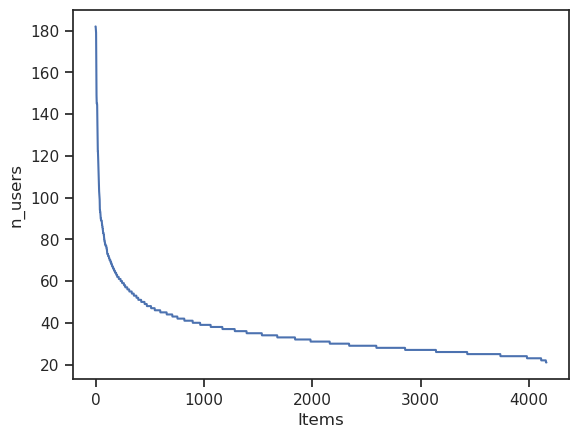

In [11]:
plot_n_users_by_item(interactions)

### Resolve unrated user items

In [12]:
if UNRATED_USER_ITEMS:
    unrated_items_by_user = ctx.interaction_service.unrated_items_by_users(interactions)
    user_item = user_items_to_pairs(unrated_items_by_user)
    del unrated_items_by_user
    user_item.to_csv(UNRATED_USER_ITEMS_PATH, encoding='utf-8', index=False, header=True)
else:
    user_item = pd.read_csv(UNRATED_USER_ITEMS_PATH)

In [13]:
!du -h {UNRATED_USER_ITEMS_PATH}

80M	../../temp/unrated_user_items.csv


In [14]:
len(user_item)

6509225

### Train Model

In [15]:
if COMPLETE_RATING_MATRIX:
    model_manager  = ml.ModelManager(
        file_path  = INPUT_INTERACTIONS_PATH,
        model      = SVD()
    )
    model_manager.train()

    user_item['rating'] = model_manager.predict(user_item)            
    user_item.to_csv(UNRATED_USER_ITEMS_COMPLETRD_PATH, encoding='utf-8', index=False, header=True)

In [16]:
if COMPLETE_RATING_MATRIX:
    complete_interactions = pd.concat([interactions, user_item], axis=0)
    complete_interactions.to_csv(COMPLETED_INTERACTIONS_PATH, encoding='utf-8', index=False, header=True)
else:
    complete_interactions = pd.read_csv(COMPLETED_INTERACTIONS_PATH)

In [17]:
complete_interactions.shape

(6656877, 3)

In [18]:
complete_interactions.head(3)

,user_id,item_id,rating
0,98.0,35,2.0
1,90.0,35,5.0
2,99.0,35,4.0


In [19]:
complete_interactions.tail(3)

,user_id,item_id,rating
6656874,5000.0,147453,4.396798
6656875,5000.0,32766,4.396798
6656876,5000.0,131071,4.396798


In [20]:
if COMPLETE_RATING_MATRIX:
    rating_matrix = ut.df_to_matrix(
        complete_interactions,
        x_col     = 'user_id',
        y_col     = 'item_id',
        value_col = 'rating'
    )

    ut.Picket.save(f'{TEMP_PATH}/rating_matrix', rating_matrix)
else:
    rating_matrix = ut.Picket.load(f'{TEMP_PATH}/rating_matrix')

In [ ]:
sns.heatmap(rating_matrix.toarray())